In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import gymnasium as gym
import numpy as np
from envs.dubins_car import DubinsCarEnv


import jax
import jax.numpy as jnp
import haiku as hk
import optax

In [2]:
jax.default_backend()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


'cpu'

In [183]:
#generate data

x_s = np.linspace(-4,4, 15)
y_s = np.linspace(-4,4, 15)
theta_s = np.linspace(0,2*np.pi, 15)

xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)
grid = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T



env = DubinsCarEnv()
state = env.reset()
X = []
y = []
for i in range(len(grid)):
    state = env.set(grid[i][0], grid[i][1], grid[i][2])
    X.append(state)

X_grid = np.array(X)
y_grid = np.array(y)
len(X_grid)


3375

In [184]:
env = DubinsCarEnv()
state = env.reset()
X = []
y = []
for i in range(1000):
    state = env.reset()
    X.append(state)
    for action in range(env.action_space.n):
        next_state, reward, done, _ = env.step(state, action, update_env=False)
        X.append(next_state)


X = np.array(X)


In [185]:
X = np.vstack([X, X_grid])
np.random.shuffle(X)
len(X)

7375

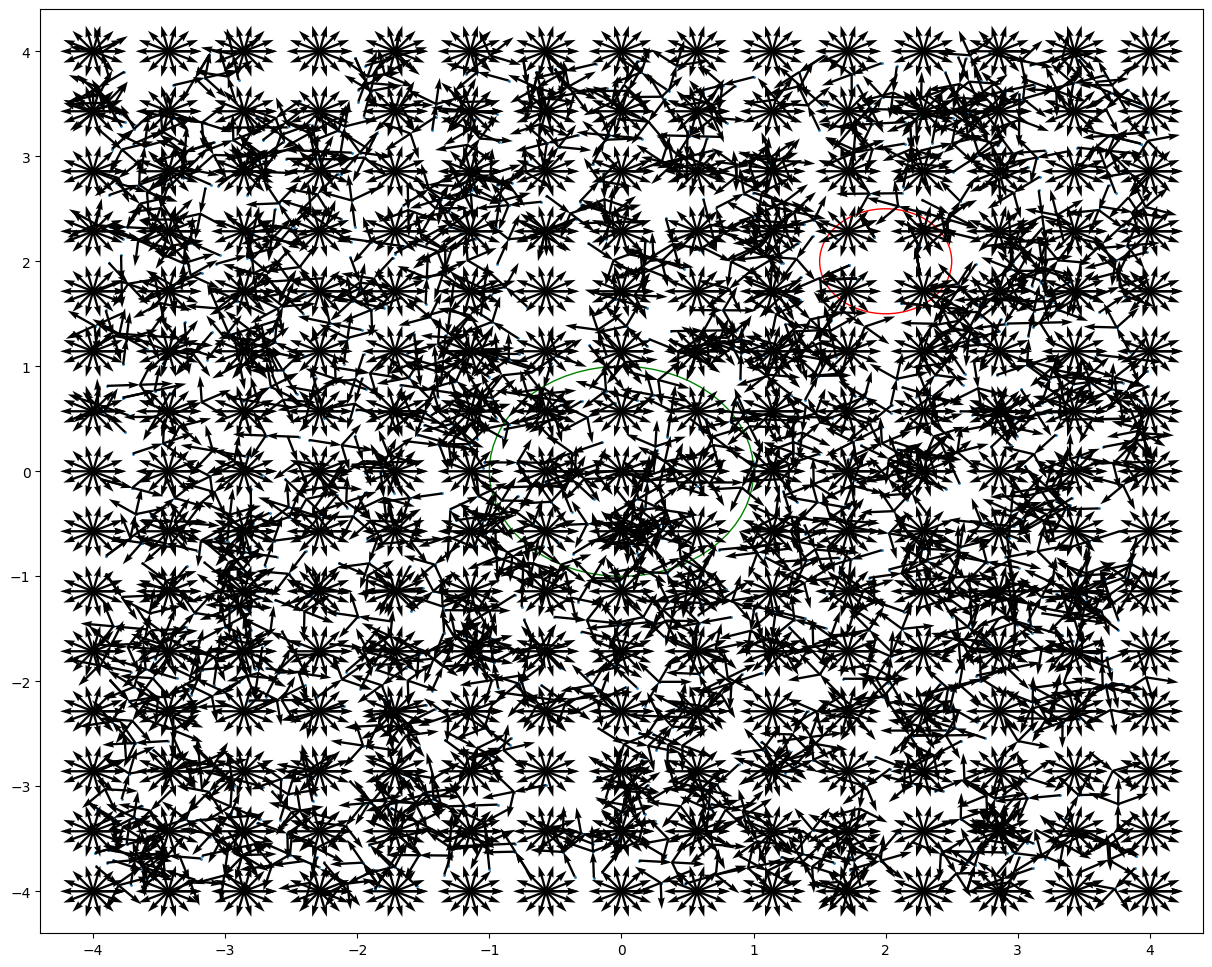

In [186]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 12]

# Plot...
plt.scatter(X[:,0], X[:,1], s=1) # s is a size of marker 
        # draw goal
goal = plt.Circle((env.goal_position[0], env.goal_position[1]), env.min_distance_to_goal, color='g', fill=False)

# draw obstacle
obstacle = plt.Circle((env.obstacle_position[0], env.obstacle_position[1]), env.obstacle_radius, color='r', fill=False)
plt.gca().add_artist(obstacle)
plt.gca().add_artist(goal)


arrow_len = env.v_max
# Calculate arrow components
arrow_dx = arrow_len * np.cos(X[:,2])
arrow_dy = arrow_len * np.sin(X[:,2])
plt.quiver(X[:,0], X[:,1], arrow_dx, arrow_dy, angles='xy', scale_units='xy', scale=1, width=0.002, color='k')


plt.jet()
#plt.show()
plt.savefig('env.png')

In [93]:
np.max(X[:,2])

6.2831855

In [94]:
2*np.pi

6.283185307179586

In [95]:
jax.local_device_count()

1

In [187]:
X = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X)))
X


array([[ 3.5138838e-03, -3.2470200e+00,  9.6851182e-01,  2.4896766e-01],
       [-5.7142860e-01, -2.2857144e+00, -9.0096885e-01,  4.3388382e-01],
       [ 1.3637910e+00, -9.1453177e-01, -7.4224621e-02,  9.9724156e-01],
       ...,
       [-2.8571429e+00, -1.1428572e+00, -6.2348980e-01,  7.8183150e-01],
       [ 2.2857144e+00, -5.7142860e-01,  1.0000000e+00,  1.7484555e-07],
       [-2.1147432e+00, -1.9817615e+00,  7.4801469e-01,  6.6368216e-01]],
      dtype=float32)

In [97]:
# import numpy as np

# def circular_positional_encoding(theta, d):
#     """
#     Encode a periodic variable using circular positional encoding.

#     Args:
#         theta (float): The value of the periodic variable to encode, in radians.
#         d (int): The number of dimensions in the encoded space.

#     Returns:
#         A numpy array of shape (d,) representing the encoded value.
#     """
#     assert theta >= 0 and theta <= 2*np.pi + 0.001, "theta must be between 0 and 2pi"
#     assert d % 2 == 0, "d must be an even number"

#     i = np.arange(d//2)
#     encoding = np.zeros((d,))
#     encoding[::2] = np.sin(theta * 2**i / (2*np.pi))
#     encoding[1::2] = np.cos(theta * 2**i / (2*np.pi))
#     return encoding

# # Example usage:
# d = 32 # The number of dimensions in the encoded space
# X_encoded = np.array([list(row[:2]) + list(circular_positional_encoding(row[2], d)) for row in X])
# print(X_encoded)



In [145]:
#params are defined *implicitly* in haiku
# def forward(X):
#     l1 = hk.Linear(16)(X)
#     l2 = jax.nn.relu(l1)
#     l3 = hk.Linear(1)(l2)

#     return l3.ravel()


#params are defined *implicitly* in haiku
def forward(X):
    l1 = hk.Linear(12)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(4)(l2)
    l4 = jax.nn.relu(l3)

    l5= hk.Linear(1)(l4)

    return l5
# def forward(X):

#     mlp = hk.nets.MLP(output_sizes=[3,1])
#     return mlp(X)

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse


jiter = jax.jit(env.sample_value_iter)


optimizer = optax.adabelief(learning_rate=10e-6)
batch_size = 100 #make it 200-50
losses = []
#check we aren't double using gradients
opt_state = optimizer.init(params)
for epoch in range(500):
    batch_loss = []
    for batch in range(0,len(X), batch_size):
        X_batch = X[batch:batch+batch_size]
        y_batch = env.sample_value_iter(X_batch, forward, params, gamma=0.95)

    
        loss, grads = jax.value_and_grad(loss_fn)(params,X=X_batch,y=y_batch)
        #print("progress:", "epoch:", epoch, "batch loss",loss)
        batch_loss.append(loss)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
    losses.append(np.mean(batch_loss))
    print('epoch', epoch, 'average loss', np.mean(batch_loss))
        
    
    
# After training
print("estimation of the parameters:")
print(params)

# estimate  = forward(X=env.reset(), params=params)
# print("estimate", estimate)

epoch 0 average loss 14.33438
epoch 1 average loss 14.322424
epoch 2 average loss 14.302312
epoch 3 average loss 14.289435
epoch 4 average loss 14.269529
epoch 5 average loss 14.2564945
epoch 6 average loss 14.236953
epoch 7 average loss 14.223835
epoch 8 average loss 14.204704
epoch 9 average loss 14.191561
epoch 10 average loss 14.172898
epoch 11 average loss 14.159708
epoch 12 average loss 14.141492
epoch 13 average loss 14.128274
epoch 14 average loss 14.110513
epoch 15 average loss 14.097259
epoch 16 average loss 14.079935
epoch 17 average loss 14.066637
epoch 18 average loss 14.049756
epoch 19 average loss 14.036433
epoch 20 average loss 14.019972
epoch 21 average loss 14.006623
epoch 22 average loss 13.990566
epoch 23 average loss 13.977195
epoch 24 average loss 13.961576
epoch 25 average loss 13.94821
epoch 26 average loss 13.933025


KeyboardInterrupt: 

In [195]:
#params are defined *implicitly* in haiku
# def forward(X):
#     l1 = hk.Linear(16)(X)
#     l2 = jax.nn.relu(l1)
#     l3 = hk.Linear(1)(l2)

#     return l3.ravel()


#params are defined *implicitly* in haiku
def forward(X):
    l1 = hk.Linear(12)(X)
    l2 = jax.nn.relu(l1)
    l3 = hk.Linear(4)(l2)
    l4 = jax.nn.relu(l3)

    l5= hk.Linear(1)(l4)

    return l5
# def forward(X):

#     mlp = hk.nets.MLP(output_sizes=[3,1])
#     return mlp(X)

# a transformed haiku function consists of an 'init' and an 'apply' function
forward = hk.without_apply_rng(hk.transform(forward))



# initialize parameters
rng = jax.random.PRNGKey(seed=14)
params = forward.init(rng, X)

# redefine 'forward' as the 'apply' function
forward = jax.jit(forward.apply)

@jax.jit
def loss_fn(params, X, y):
    err = forward(params, X) - y
    return jnp.mean(jnp.square(err))  # mse




optimizer = optax.adabelief(learning_rate=10e-6)
batch_size = 100 #make it 200-50
losses = []
#check we aren't double using gradients
opt_state = optimizer.init(params)


@jax.jit
def train_step(params, X_batch, y_batch, opt_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, X=X_batch, y=y_batch)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return loss, params, opt_state

for epoch in range(200):
    epoch_loss = 0.0
    opt_state = optimizer.init(params)
    for batch in range(0, len(X), batch_size):
        X_batch = X[batch:batch+batch_size]
        y_batch = env.sample_value_iter(X_batch, forward, params, gamma=0.98)
        loss, params, opt_state = train_step(params, X_batch, y_batch, opt_state)
        epoch_loss += loss
    epoch_loss /= (len(X) // batch_size)
    losses.append(epoch_loss)
    print('epoch', epoch, 'average loss', epoch_loss)




epoch 0 average loss 15.088581
epoch 1 average loss 15.067685
epoch 2 average loss 15.0513115
epoch 3 average loss 15.030708
epoch 4 average loss 15.014524
epoch 5 average loss 14.994178
epoch 6 average loss 14.978105
epoch 7 average loss 14.957981
epoch 8 average loss 14.94202
epoch 9 average loss 14.922097
epoch 10 average loss 14.906299
epoch 11 average loss 14.886521
epoch 12 average loss 14.870816
epoch 13 average loss 14.851201
epoch 14 average loss 14.835583
epoch 15 average loss 14.816075
epoch 16 average loss 14.800597
epoch 17 average loss 14.781155
epoch 18 average loss 14.765607
epoch 19 average loss 14.746313
epoch 20 average loss 14.730961
epoch 21 average loss 14.711925
epoch 22 average loss 14.696691
epoch 23 average loss 14.677716
epoch 24 average loss 14.6625
epoch 25 average loss 14.643741
epoch 26 average loss 14.628764
epoch 27 average loss 14.6103115
epoch 28 average loss 14.595561
epoch 29 average loss 14.577379
epoch 30 average loss 14.562903
epoch 31 average lo

KeyboardInterrupt: 

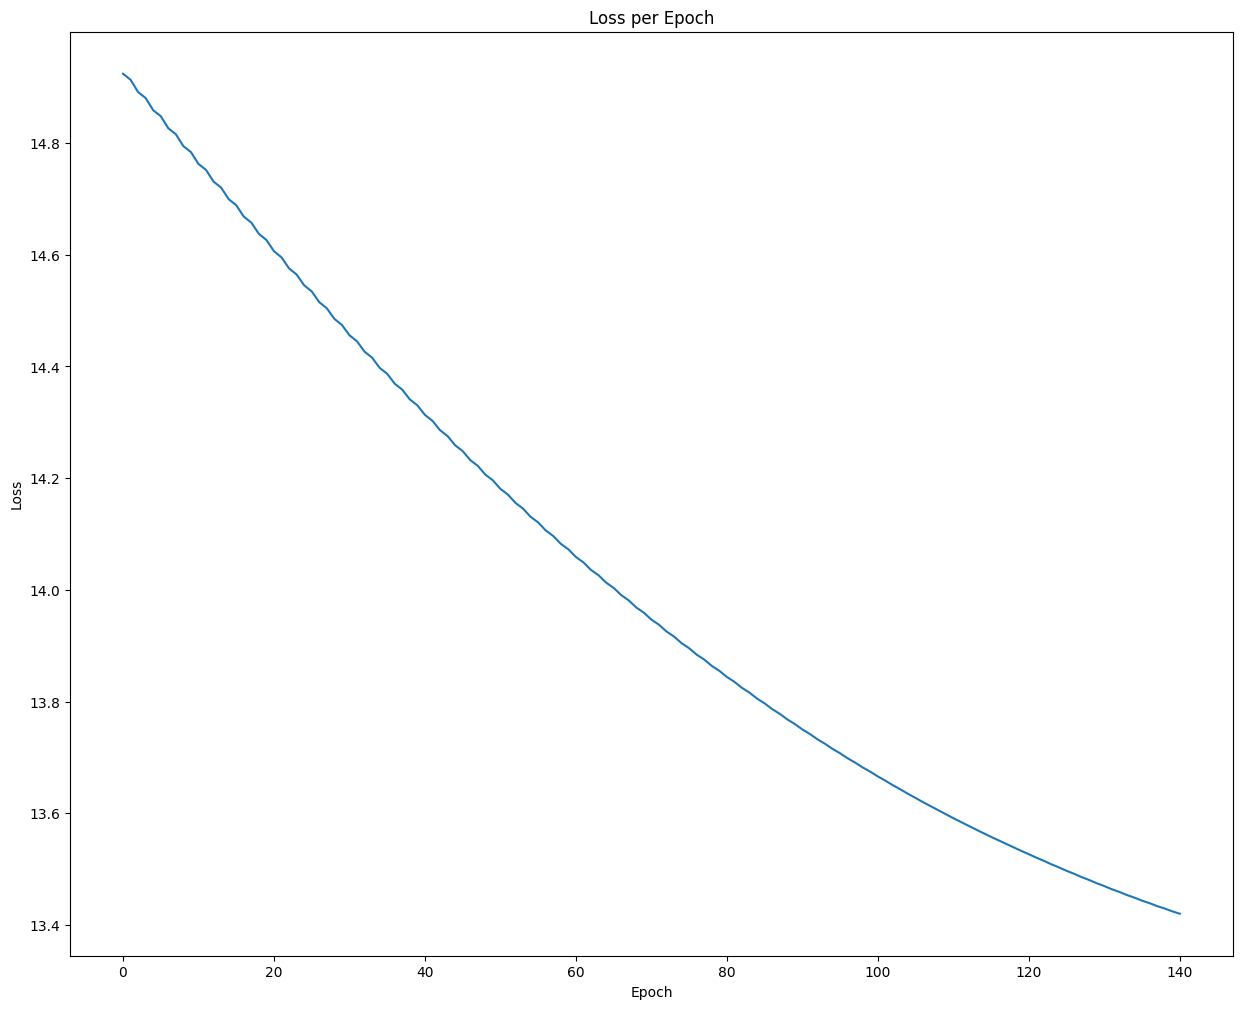

In [189]:
# Plot the losses
lo = [l.item() for l in losses]

plt.plot(lo)

# Add a title and labels to the x and y axis
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Show the plot
plt.savefig('losses_3.png')

plt.show()

In [10]:
env = DubinsCarEnv()
state = env.reset()
X_val = []
for i in range(1000):
    state = env.reset()
    X_val.append(state)
    for action in range(env.action_space.n):
        next_state, reward, done, _ = env.step(state, action, update_env=False)
        X_val.append(next_state)


X_val = np.array(X_val)
X_val_encoded = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X_val)))


/ifs/CS/replicated/home/apraka15/Desktop/Projects/Reach-Avoid/gym-examples/.env/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [17]:
#generate data

x_s = np.linspace(-4,4, 15)
y_s = np.linspace(-4,4, 15)
theta_s = np.linspace(0,2*np.pi, 15)

xx, yy, tt = np.meshgrid(x_s, y_s, theta_s)
grid_val = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T



env = DubinsCarEnv()
state = env.reset()
X_val = []
for i in range(len(grid_val)):
    state = env.set(grid_val[i][0], grid_val[i][1], grid_val[i][2])
    X_val.append(state)

X_val = np.array(X_val)

X_val_encoded = np.array(list(map(lambda row: (row[0], row[1], np.cos(row[2]), np.sin(row[2])), X_val)))
X_val_encoded

array([[-4.0000000e+00, -4.0000000e+00,  1.0000000e+00,  0.0000000e+00],
       [-4.0000000e+00, -4.0000000e+00,  9.0096885e-01,  4.3388376e-01],
       [-4.0000000e+00, -4.0000000e+00,  6.2348980e-01,  7.8183150e-01],
       ...,
       [ 4.0000000e+00,  4.0000000e+00,  6.2348962e-01, -7.8183162e-01],
       [ 4.0000000e+00,  4.0000000e+00,  9.0096885e-01, -4.3388376e-01],
       [ 4.0000000e+00,  4.0000000e+00,  1.0000000e+00,  1.7484555e-07]],
      dtype=float32)

In [196]:
y_pred = [forward(X=x, params=params) for x in X_val_encoded]

In [197]:
y_pred

[Array([0.9943438], dtype=float32),
 Array([0.9829935], dtype=float32),
 Array([0.9074903], dtype=float32),
 Array([0.7785463], dtype=float32),
 Array([0.61941785], dtype=float32),
 Array([0.4616224], dtype=float32),
 Array([0.33641323], dtype=float32),
 Array([0.27510926], dtype=float32),
 Array([0.28313178], dtype=float32),
 Array([0.34503654], dtype=float32),
 Array([0.4733238], dtype=float32),
 Array([0.64258486], dtype=float32),
 Array([0.81473756], dtype=float32),
 Array([0.9302862], dtype=float32),
 Array([0.9943438], dtype=float32),
 Array([0.7646752], dtype=float32),
 Array([0.76056814], dtype=float32),
 Array([0.71064407], dtype=float32),
 Array([0.6129391], dtype=float32),
 Array([0.46974036], dtype=float32),
 Array([0.3226917], dtype=float32),
 Array([0.20091788], dtype=float32),
 Array([0.12853774], dtype=float32),
 Array([0.12495621], dtype=float32),
 Array([0.18923162], dtype=float32),
 Array([0.3049309], dtype=float32),
 Array([0.44913864], dtype=float32),
 Array([0.593

In [198]:
max(y_pred)

Array([0.9943438], dtype=float32)

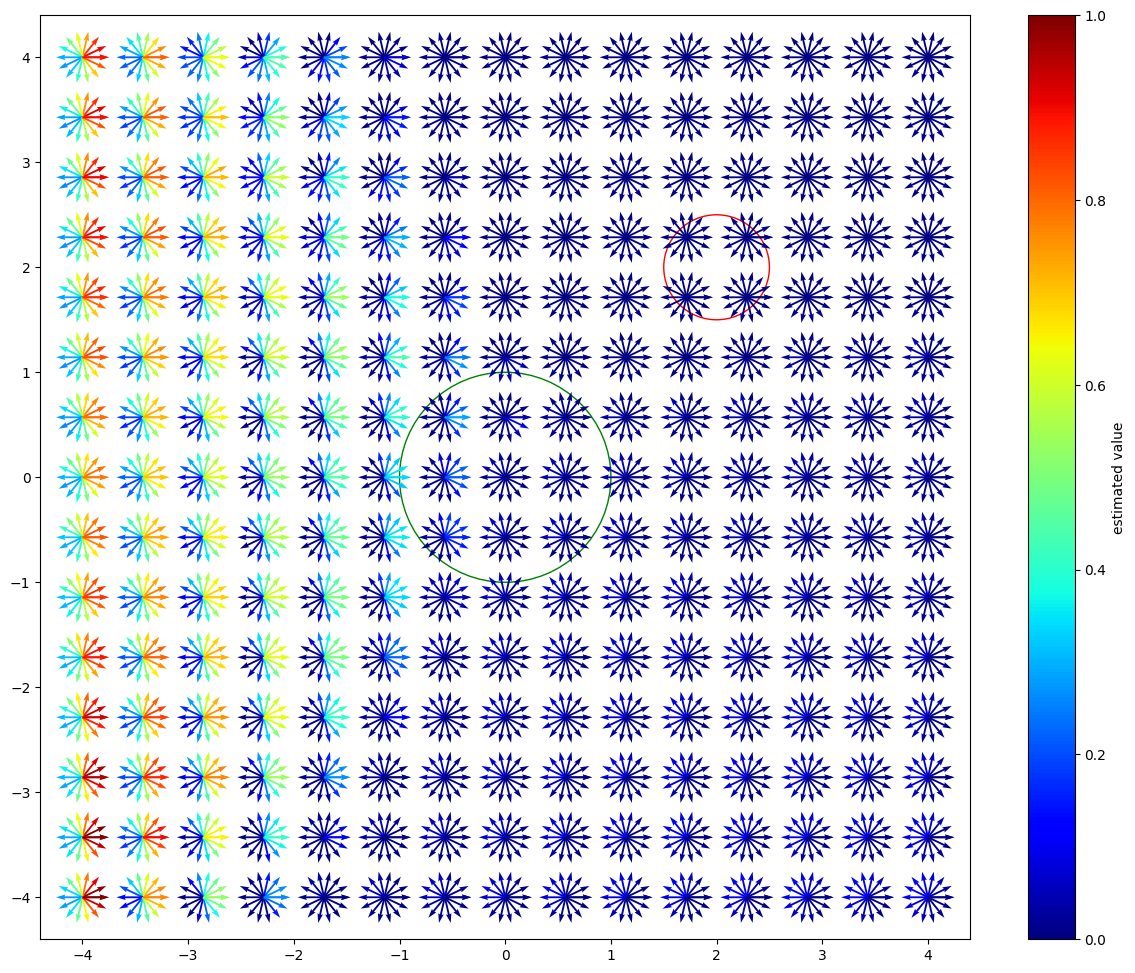

In [199]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm


# Plot...
plt.scatter(X_val[:,0], X_val[:,1], s=1) # s is a size of marker 
plt.jet()
plt.colorbar(label='estimated value')
#plt.savefig('500_iter_adabeleif_.85gamma.png')
#plt.show()

#draw goal
goal = plt.Circle((env.goal_position[0], env.goal_position[1]), env.min_distance_to_goal, color='g', fill=False)

# draw obstacle
obstacle = plt.Circle((env.obstacle_position[0], env.obstacle_position[1]), env.obstacle_radius, color='r', fill=False)
plt.gca().add_artist(obstacle)
plt.gca().add_artist(goal)


arrow_len = env.v_max
# Calculate arrow components
arrow_dx = arrow_len * np.cos(X_val[:,2])
arrow_dy = arrow_len * np.sin(X_val[:,2])

arrow_colors = cm.jet(y_pred/np.max(y_pred))


plt.quiver(X_val[:,0], X_val[:,1], arrow_dx, arrow_dy, angles='xy', scale_units='xy', scale=1, width=0.002, color=arrow_colors)


plt.jet()
#plt.savefig('500_iter_adabeleif_.95gamma_grid.png')


In [34]:
len(X)

5500

In [205]:
#train on small steps, run on bigger steps?
right = 0
up = np.pi / 2
down = 3 * np.pi / 2
left = np.pi

env = DubinsCarEnv()
state = env.set(3, 3, right)
#state = env.reset()

gamma = 0.85
traj = []
done = False
max_iter = 50
counter = 0
while (not done) and (counter < max_iter):
    counter+=1
    possible_actions = []
    for a in range(env.action_space.n):
        next_state, reward, done, _ = env.step(state, a, update_env=False)
        #estimate = forward(X=next_state, params=params)
        estimate = forward(X=np.array([next_state[0], next_state[1], np.cos(next_state[2]), np.sin(next_state[2])]), params=params)

        value = reward + gamma*estimate[0]
        print('estimate', value)
        print('state:',next_state)

        possible_actions.append(value)

    action = np.argmax(np.array(possible_actions))
    print('next_states', action, possible_actions)
    traj.append(state)
    state, reward, done, _ = env.step(action=action, update_env=True)
    env.render()
    print(counter)
    
env.make_gif()

estimate -0.15125781
state: [3.25     3.       5.148721]
estimate -0.16210043
state: [3.25 3.   0.  ]
estimate -0.18770596
state: [3.25     3.       1.134464]
next_states 0 [Array(-0.15125781, dtype=float32), Array(-0.16210043, dtype=float32), Array(-0.18770596, dtype=float32)]
1
estimate -0.15752594
state: [3.3556545 2.773423  4.0142574]
estimate -0.13221794
state: [3.3556545 2.773423  5.148721 ]
estimate -0.14325054
state: [3.3556545 2.773423  6.283185 ]
next_states 1 [Array(-0.15752594, dtype=float32), Array(-0.13221794, dtype=float32), Array(-0.14325054, dtype=float32)]
2
estimate -0.12919448
state: [3.461309  2.546846  4.0142574]
estimate -0.11330924
state: [3.461309 2.546846 5.148721]
estimate -0.124400765
state: [3.461309 2.546846 6.283185]
next_states 1 [Array(-0.12919448, dtype=float32), Array(-0.11330924, dtype=float32), Array(-0.12440076, dtype=float32)]
3
estimate -0.10086304
state: [3.5669634 2.3202689 4.0142574]
estimate -0.09445947
state: [3.5669634 2.3202689 5.148721 ]


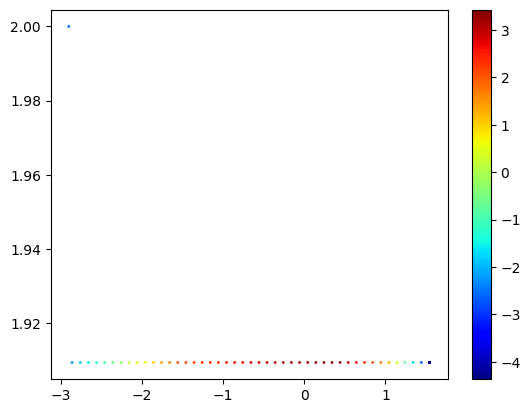

: 

In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
t = np.array([traj])
yp = [forward(X=x, params=params) for x in t]

# Plot...
plt.scatter(np.array(traj)[:,0], np.array(traj)[:,1], c=yp, s=1) # s is a size of marker 
plt.jet()
plt.colorbar()
plt.show()
#plt.savefig('500_iter.png')

In [ ]:
10*estimate

Array([-31.93895], dtype=float32)

: 

In [ ]:
possible_actions

[Array(-12.71481, dtype=float32),
 Array(-12.356915, dtype=float32),
 Array(-12.71481, dtype=float32)]

: 

In [ ]:
np.argmax(possible_actions)

1

: 

In [ ]:
forward(X=np.array([3,3,0, 0]), params=params) 

Array([-2.9606214], dtype=float32)

: 

In [ ]:
forward(X=np.array([3,3,1, 1]), params=params) 

Array([-2.536736], dtype=float32)

: 

In [ ]:
#plot with arrows and try without obstacle. 

: 